In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.datasets import fetch_olivetti_faces
import scipy
from scipy import fftpack

# Импорт данных

In [2]:
df = fetch_olivetti_faces()

In [3]:
df.images.shape

(400, 64, 64)

In [4]:
df.data.shape

(400, 4096)

In [5]:
def plot_3(data, num_photo):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (15,6))
    ax4.imshow(data[num_photo[0]], cmap=plt.cm.gray)
    ax5.imshow(data[num_photo[1]], cmap=plt.cm.gray)
    ax6.imshow(data[num_photo[2]], cmap=plt.cm.gray)
    ax1.imshow(df.images[num_photo[0]], cmap=plt.cm.gray)
    ax2.imshow(df.images[num_photo[1]], cmap=plt.cm.gray)
    ax3.imshow(df.images[num_photo[2]], cmap=plt.cm.gray)

In [6]:
def plot_3_hist(data, num_photo):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (15,6))
    ax4.hist(data[num_photo[0]])
    ax5.hist(data[num_photo[1]])
    ax6.hist(data[num_photo[2]])
    ax1.imshow(df.images[num_photo[0]], cmap=plt.cm.gray)
    ax2.imshow(df.images[num_photo[1]], cmap=plt.cm.gray)
    ax3.imshow(df.images[num_photo[2]], cmap=plt.cm.gray)

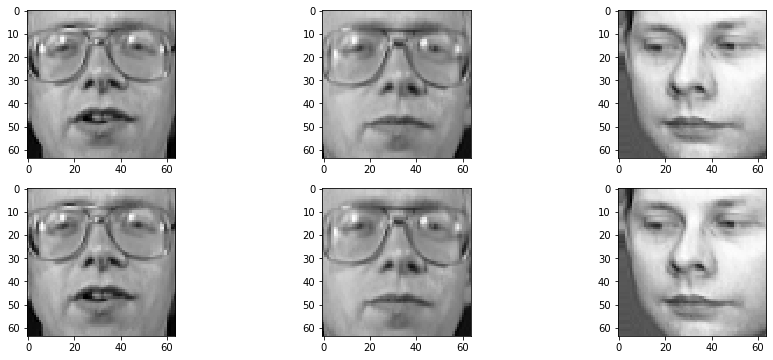

In [7]:
plot_3(df.images, [10, 11, 35])

In [8]:
def hist_data(data, count_col):
    histed_data = []
    for img in data:
        hist = np.histogram(img, count_col)
        histed_data.append(hist[0])
    return np.array(histed_data)

In [9]:
def scale_data(data, scale):
    scaled_data = []
    for img in data:
        shape = img.shape[0]
        width = int(shape * scale)
        dim = (width, width)
        scaled_data.append(cv2.resize(img, dim))
    return np.array(scaled_data)

In [10]:
def dft_data(data, matrix_size):
    dfted_data = []
    for img in data:
        dft = np.fft.fft2(img)
        dft = np.real(dft)
        dfted_data.append(dft[:matrix_size, :matrix_size])
    return np.array(dfted_data)

In [11]:
def dct_data(data, matrix_size):
    dcted_data = []
    for img in data:
        dct = scipy.fftpack.dct(img, axis=1)
        dct = scipy.fftpack.dct(dct, axis=0)
        dcted_data.append(dct[:matrix_size,:matrix_size])
    return np.array(dcted_data)

In [12]:
def gradient_data(data, height):
    gradiented_data = []
    for img in data:
        shape = img.shape[0]
        i = 1
        result = []
        while (i) * height + 2 * height <= shape:
            prev = np.array(img[i * height:(i) * height + height, :])
            next =  np.array(img[(i) * height + height:(i) * height + 2 * height, :])
            result.append(prev - next)
            i += 1
        result = np.array(result)
        result = result.reshape((result.shape[0] * result.shape[1], result.shape[2]))
        result = np.mean(result, axis=0)
        gradiented_data.append(result)
    return np.array(gradiented_data)

# Примеры

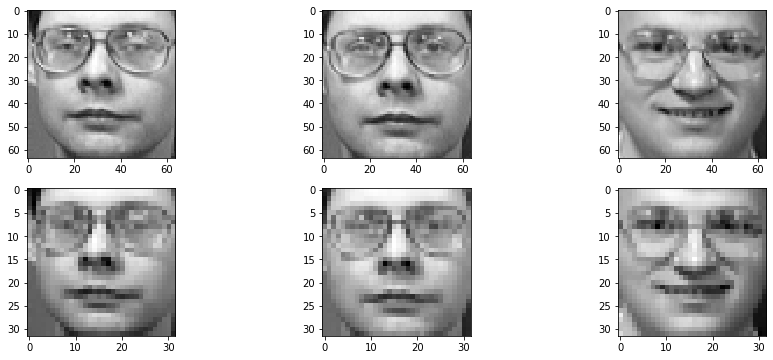

In [13]:
new_show_df = scale_data(df.images, 0.5)  
plot_3(new_show_df, [32, 30, 51])

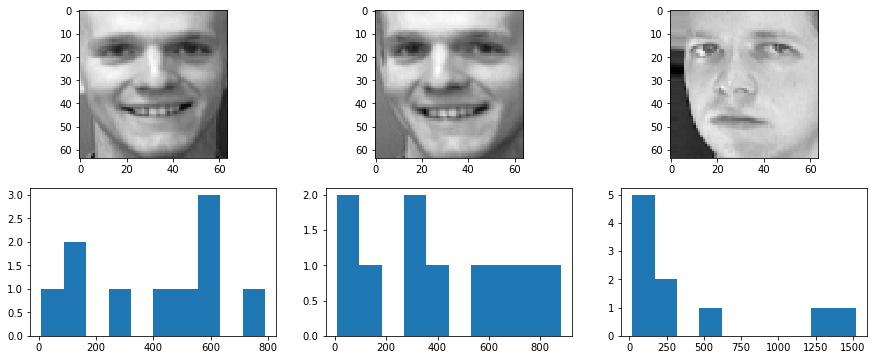

In [14]:
new_show_df = hist_data(df.images, 10)
plot_3_hist(new_show_df, [41, 43, 5])

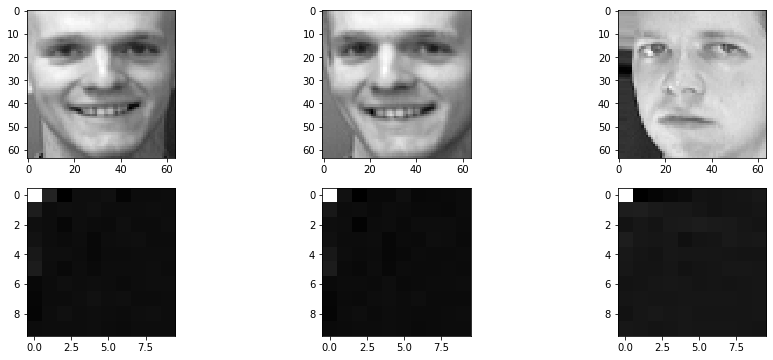

In [15]:
new_show_df = dct_data(df.images, 10)
plot_3(new_show_df, [41, 43, 5])

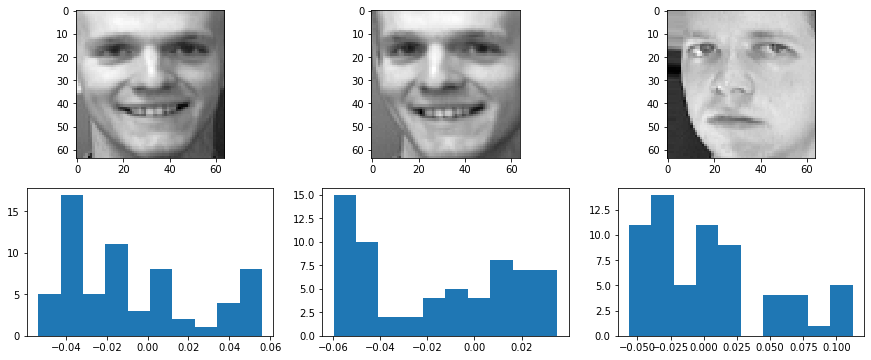

In [16]:
new_show_df = gradient_data(df.images, 10)
plot_3_hist(new_show_df, [41, 43, 5])

# Подбор параметров и тестирование

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [18]:
from mpl_toolkits.mplot3d import Axes3D
def plot3d(array_acc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(np.array(array_acc)[:,1]*10, np.array(array_acc)[:,0], np.array(array_acc)[:,2], color='red', depthshade=False)
    ax.set_xlabel('Количество тестовых изображений')
    ax.set_ylabel('Параметры')
    ax.set_zlabel('Точность')
    fig.set_figwidth(9)
    fig.set_figheight(9)

In [19]:
def get_best_param(method, params, test_sizes):
    best_score = 0
    params_acc = []
    for param in params:
        for size in test_sizes:
            neigh = KNeighborsClassifier(n_neighbors=1)
            X = method(df.images, param)
            y = df.target
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, stratify=y, random_state=24)
            X_train = X_train.reshape(X_train.shape[0],-1)
            #acc_array = cross_val_score(neigh, X_train, y_train, cv=3)
            #final_acc = acc_array.mean()
            neigh.fit(X_train, y_train)
            X_test = X_test.reshape(X_test.shape[0],-1)
            y_predicted = neigh.predict(X_test)
            final_acc = accuracy_score(y_predicted, y_test)
            params_acc.append([param, size, final_acc])
            if final_acc > best_score:
                best_params = [param, size]
                best_score = final_acc
    plot3d(params_acc)
    return best_params, best_score, params_acc

In [20]:
test_sizes = [0.1*i for i in range(1, 10)]

Лучший параметр: 30
Количество эталонов: 1.0
Количество тестовых изображений: 9.0
Лучший результат:0.85


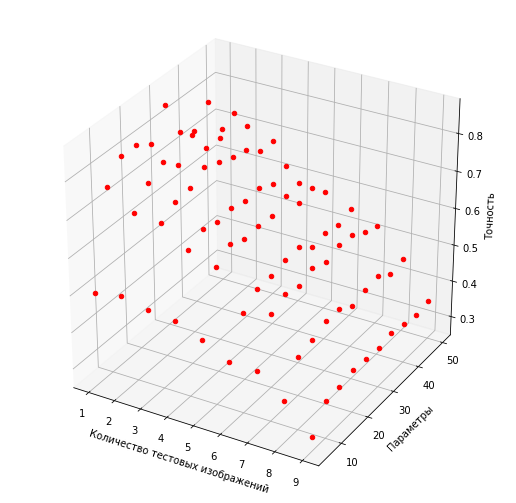

In [21]:
params = [5*i for i in range(1, 11)]
best_params_hist, best_score, array_acc = get_best_param(hist_data, params, test_sizes)
print("Лучший параметр: {0}\nКоличество эталонов: {1}\nКоличество тестовых изображений: {2}\nЛучший результат:{3}".format(best_params_hist[0], best_params_hist[1]*10, 10 - best_params_hist[1]*10, best_score))

Лучший параметр: 0.5
Количество эталонов: 1.0
Количество тестовых изображений: 9.0
Лучший результат:1.0


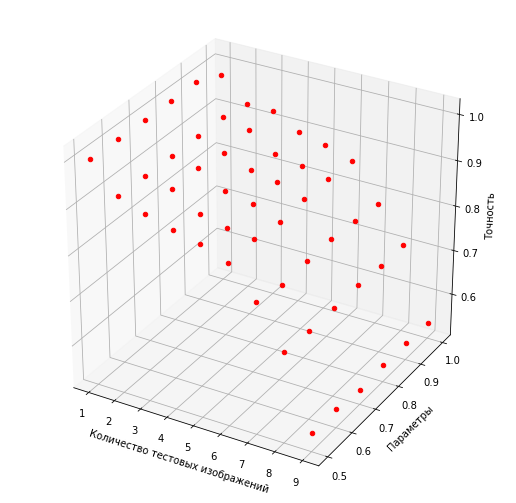

In [22]:
params = [0.1*i for i in range(5, 11)]
best_params_scale, best_score, array_acc = get_best_param(scale_data, params, test_sizes)
print("Лучший параметр: {0}\nКоличество эталонов: {1}\nКоличество тестовых изображений: {2}\nЛучший результат:{3}".format(best_params_scale[0], best_params_scale[1]*10, 10 - best_params_scale[1]*10, best_score))

Лучший параметр: 4
Количество эталонов: 1.0
Количество тестовых изображений: 9.0
Лучший результат:0.95


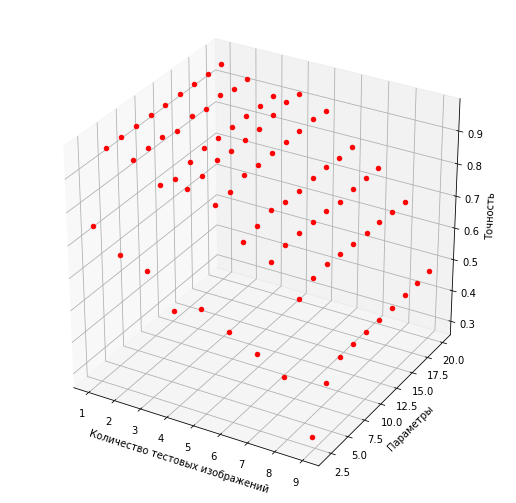

In [23]:
params = [2*i for i in range(1, 11)]
best_params_dft, best_score, array_acc = get_best_param(dft_data, params, test_sizes)
print("Лучший параметр: {0}\nКоличество эталонов: {1}\nКоличество тестовых изображений: {2}\nЛучший результат:{3}".format(best_params_dft[0], best_params_dft[1]*10, 10 - best_params_dft[1]*10, best_score))

Лучший параметр: 6
Количество эталонов: 1.0
Количество тестовых изображений: 9.0
Лучший результат:1.0


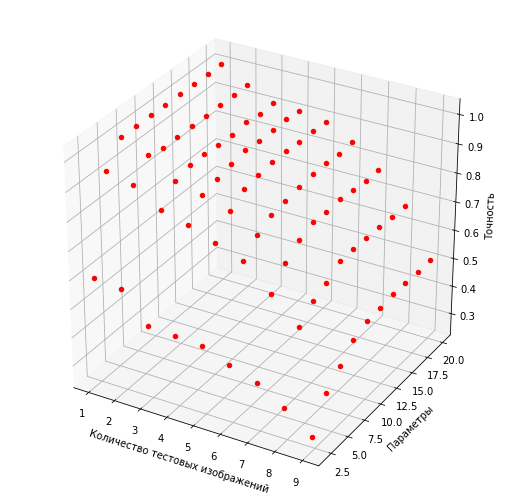

In [24]:
params = [2*i for i in range(1, 11)]
best_params_dct, best_score, array_acc = get_best_param(dct_data, params, test_sizes)
print("Лучший параметр: {0}\nКоличество эталонов: {1}\nКоличество тестовых изображений: {2}\nЛучший результат:{3}".format(best_params_dct[0], best_params_dct[1]*10, 10 - best_params_dct[1]*10, best_score))

Лучший параметр: 16
Количество эталонов: 1.0
Количество тестовых изображений: 9.0
Лучший результат:0.9


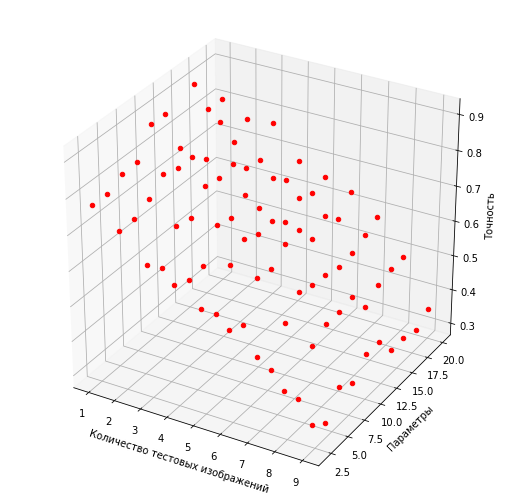

In [25]:
params = [2*i for i in range(1, 11)]
best_params_gradient, best_score, array_acc = get_best_param(gradient_data, params, test_sizes)
print("Лучший параметр: {0}\nКоличество эталонов: {1}\nКоличество тестовых изображений: {2}\nЛучший результат:{3}".format(best_params_gradient[0], best_params_gradient[1]*10, 10 - best_params_gradient[1]*10, best_score))

# Параллельная сиситема

In [26]:
import collections

In [27]:
def get_predict(method, param, size):
    neigh = KNeighborsClassifier(n_neighbors=1)
    X = method(df.images, param)
    y = df.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, stratify=y, random_state=24)
    X_train = X_train.reshape(X_train.shape[0],-1)
    neigh.fit(X_train, y_train)
    X_test = X_test.reshape(X_test.shape[0],-1)
    y_predicted = neigh.predict(X_test)
    return y_predicted, y_test

In [28]:
def par_sistem(methods, test_sizes, params):
    full_acc = []
    for size in test_sizes:
        array_cls_acc = []
        array_y_pred = []
        par_sistem_y_pred = []
        for i in range(len(methods)):
            y_pred, y_test = get_predict(methods[i], params[i], size)
            array_cls_acc.append(accuracy_score(y_pred, y_test))
            array_y_pred.append(y_pred)
        array_y_pred = np.array(array_y_pred)
        for j in range(array_y_pred.shape[1]):
            par_sistem_y_pred.append(collections.Counter(array_y_pred[:,j]).most_common(1)[0][0])
        array_cls_acc.append(accuracy_score(par_sistem_y_pred, y_test))
        full_acc.append(array_cls_acc)
    return np.array(full_acc)

In [29]:
methods = [hist_data, scale_data, dft_data, dct_data, gradient_data]
test_sizes = [0.1*i for i in range(1, 10)]
params = [best_params_hist[0], best_params_scale[0], best_params_dft[0], best_params_dct[0], best_params_gradient[0]]

In [30]:
full_acc = par_sistem(methods, test_sizes, params)

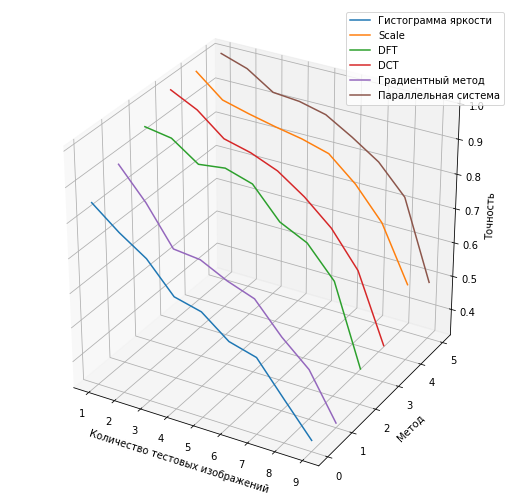

In [31]:
x = np.array(test_sizes)*10
y = [0 for i in test_sizes]
y1 = [4 for i in test_sizes]
y2 = [2 for i in test_sizes]
y3 = [3 for i in test_sizes]
y4 = [1 for i in test_sizes]
y5 = [5 for i in test_sizes]

z = full_acc[:,0]
z1 = full_acc[:,1]
z2 =  full_acc[:, 2]
z3 = full_acc[:,3]
z4 = full_acc[:,4]
z5 = full_acc[:,5]

fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(9)

ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Гистограмма яркости')
ax.plot(x, y1, z1, label='Scale')
ax.plot(x, y2, z2, label='DFT')
ax.plot(x, y3, z3, label='DCT')
ax.plot(x, y4, z4, label='Градиентный метод')
ax.plot(x, y5, z5, label='Параллельная система')

ax.set_xlabel('Количество тестовых изображений')
ax.set_ylabel('Метод')
ax.set_zlabel('Точность')

ax.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

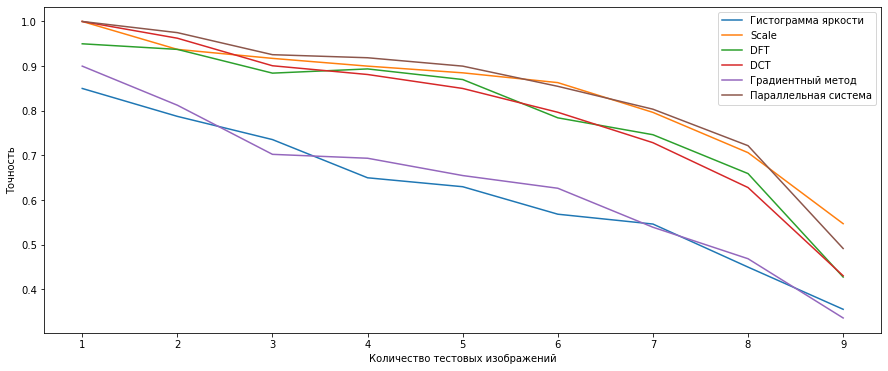

In [32]:
x = np.array(test_sizes)*10

z = full_acc[:,0]
z1 = full_acc[:,1]
z2 =  full_acc[:, 2]
z3 = full_acc[:,3]
z4 = full_acc[:,4]
z5 = full_acc[:,5]

fig = plt.figure()


fig, (ax) = plt.subplots(figsize = (15,6))
ax.plot(x, z, label='Гистограмма яркости')
ax.plot(x, z1, label='Scale')
ax.plot(x, z2, label='DFT')
ax.plot(x, z3, label='DCT')
ax.plot(x, z4, label='Градиентный метод')
ax.plot(x, z5, label='Параллельная система')

ax.set_xlabel('Количество тестовых изображений')
ax.set_ylabel('Точность')

ax.legend()
plt.show()

In [33]:
import pandas as pd

In [34]:
table = pd.DataFrame(full_acc, columns=['Гистограмма яркости', 'Scale', 'DFT', 'DCT', 'Градиентный метод', 'Параллельная система'])

In [60]:
index = ['9/1 | 360/40','8/2 | 320/80','7/3 | 280/120','6/4 | 240/160','5/5 | 200/200','4/6 | 160/240','3/7 | 120/280','2/8 | 80/320','1/9 | 40/360']

In [61]:
table.index = index

In [62]:
table

,Гистограмма яркости,Scale,DFT,DCT,Градиентный метод,Параллельная система
9/1 | 360/40,0.850000,1.000000,0.950000,1.000000,0.900000,1.000000
8/2 | 320/80,0.787500,0.937500,0.937500,0.962500,0.812500,0.975000
7/3 | 280/120,0.735537,0.917355,0.884298,0.900826,0.702479,0.925620
6/4 | 240/160,0.650000,0.900000,0.893750,0.881250,0.693750,0.918750
5/5 | 200/200,0.630000,0.885000,0.870000,0.850000,0.655000,0.900000
4/6 | 160/240,0.568465,0.863071,0.784232,0.796680,0.626556,0.854772
3/7 | 120/280,0.546429,0.796429,0.746429,0.728571,0.539286,0.803571
2/8 | 80/320,0.450000,0.706250,0.659375,0.628125,0.468750,0.721875
1/9 | 40/360,0.355556,0.547222,0.427778,0.430556,0.336111,0.491667


In [66]:
table.index.name = 'Вариант разделения'

In [67]:
table

,Гистограмма яркости,Scale,DFT,DCT,Градиентный метод,Параллельная система
Вариант разделения,,,,,,
9/1 | 360/40,0.850000,1.000000,0.950000,1.000000,0.900000,1.000000
8/2 | 320/80,0.787500,0.937500,0.937500,0.962500,0.812500,0.975000
7/3 | 280/120,0.735537,0.917355,0.884298,0.900826,0.702479,0.925620
6/4 | 240/160,0.650000,0.900000,0.893750,0.881250,0.693750,0.918750
5/5 | 200/200,0.630000,0.885000,0.870000,0.850000,0.655000,0.900000
4/6 | 160/240,0.568465,0.863071,0.784232,0.796680,0.626556,0.854772
3/7 | 120/280,0.546429,0.796429,0.746429,0.728571,0.539286,0.803571
2/8 | 80/320,0.450000,0.706250,0.659375,0.628125,0.468750,0.721875
1/9 | 40/360,0.355556,0.547222,0.427778,0.430556,0.336111,0.491667
